In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

%matplotlib inline

## Data Preprocessing

In this section, we perform initial data cleaning and exploration. The steps include:

1. Converting column names to lowercase and replacing spaces with underscores.
2. Transforming string columns to lowercase and replacing spaces with underscores.

In [3]:
source_df = pd.read_csv('../data/data.csv')

In [4]:
df = source_df.copy()

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   customer_type                      129880 non-null  object 
 2   age                                129880 non-null  int64  
 3   type_of_travel                     129880 non-null  object 
 4   class                              129880 non-null  object 
 5   flight_distance                    129880 non-null  int64  
 6   seat_comfort                       129880 non-null  int64  
 7   departure/arrival_time_convenient  129880 non-null  int64  
 8   food_and_drink                     129880 non-null  int64  
 9   gate_location                      129880 non-null  int64  
 10  inflight_wifi_service              129880 non-null  int64  
 11  inflight_entertainment             1298

### Feature Selection
Selecting features that are available before the flight.

In [4]:
# features unavalable before the flight 
columns_to_remove = [
    'seat_comfort', 
    'departure/arrival_time_convenient', 
    'food_and_drink', 
    'gate_location', 
    'inflight_wifi_service', 
    'inflight_entertainment', 
    'on-board_service', 
    'leg_room_service', 
    'baggage_handling', 
    'checkin_service', 
    'cleanliness', 
    'departure_delay_in_minutes', 
    'arrival_delay_in_minutes',
    'online_support',
]

df = df.drop(columns=columns_to_remove)

df.head()

,satisfaction,customer_type,age,type_of_travel,class,flight_distance,ease_of_online_booking,online_boarding
0,satisfied,loyal_customer,65,personal_travel,eco,265,3,2
1,satisfied,loyal_customer,47,personal_travel,business,2464,3,2
2,satisfied,loyal_customer,15,personal_travel,eco,2138,2,2
3,satisfied,loyal_customer,60,personal_travel,eco,623,1,3
4,satisfied,loyal_customer,70,personal_travel,eco,354,2,5


### Data Transformation: Encoding Categorical Variables
Transforming categorical variables into numerical ones.

In [5]:
df['satisfaction'] = df['satisfaction'].replace({'satisfied': 1, 'dissatisfied': 0})
df['customer_type'] = df['customer_type'].replace({'loyal_customer': 1, 'disloyal_customer': 0})
df['type_of_travel'] = df['type_of_travel'].replace({'business_travel': 1, 'personal_travel': 0})

df = pd.get_dummies(df, columns=['class'], prefix='class')

df.dtypes

satisfaction              int64
customer_type             int64
age                       int64
type_of_travel            int64
flight_distance           int64
ease_of_online_booking    int64
online_boarding           int64
class_business            uint8
class_eco                 uint8
class_eco_plus            uint8
dtype: object

### Data Exploration: Correlation Analysis
Analyzing the correlation between features and the target variable.

In [6]:
corr_matrix = df.corr(numeric_only=True)
corr_with_target = corr_matrix['satisfaction'].sort_values(ascending=False)
print(corr_with_target)

satisfaction              1.000000
ease_of_online_booking    0.431772
online_boarding           0.338147
class_business            0.311912
customer_type             0.292592
age                       0.117971
type_of_travel            0.109239
flight_distance          -0.039224
class_eco_plus           -0.067537
class_eco                -0.278062
Name: satisfaction, dtype: float64


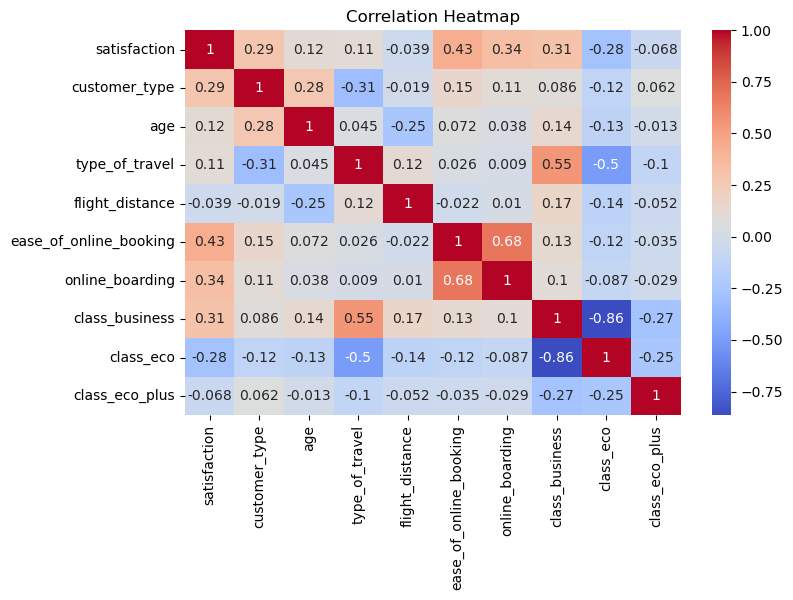

In [7]:
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix.round(3), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Data Quality Check: Missing Values
Checking for missing values in the dataset.

In [8]:
df.isnull().sum()

satisfaction              0
customer_type             0
age                       0
type_of_travel            0
flight_distance           0
ease_of_online_booking    0
online_boarding           0
class_business            0
class_eco                 0
class_eco_plus            0
dtype: int64

## Utility Functions
Utility functions for data splitting and model evaluation.

In [9]:
RANDOM_STATE = 42

def split_x_y(df):
    """
    Splits a DataFrame into features (X) and target (y) variables.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to split.
    
    Returns:
    - X (pd.DataFrame): DataFrame containing the features.
    - y (pd.Series): Series containing the target variable.
    """
    
    X = df.drop('satisfaction', axis=1)
    y = df['satisfaction']
    return X, y

def split_data(df, features, target='satisfaction', random_state=RANDOM_STATE):
    """
    Splits a DataFrame into training, validation, and test sets.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to split.
    - features (list): List of feature column names.
    - target (str): Name of the target column.
    - random_state (int): Random state for reproducibility.
    
    Returns:
    - df_train (pd.DataFrame): Training set.
    - df_val (pd.DataFrame): Validation set.
    - df_test (pd.DataFrame): Test set.
    - df_train_full (pd.DataFrame): Full training set (training + validation).
    """
    
    wip_df = df[features + [target]]

    df_train_full, df_test = train_test_split(wip_df, test_size=0.2, random_state=random_state)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=random_state)
    
    return df_train, df_val, df_test, df_train_full
        
def evaluate_param(
    param_name, param_values, n_estimators_values, X_train, y_train, X_val, y_val, fixed_params={}):
    """
    Trains a RandomForestClassifier model with varying values of a single parameter and stores the metrics.
    
    Parameters:
    - param_name (str): The name of the parameter to vary (e.g., 'max_depth' or 'min_samples_leaf').
    - param_values (list): List of parameter values to explore.
    - fixed_params (dict): Fixed parameters for the model.
    - X_train, y_train (np.array): Training dataset.
    - X_val, y_val (np.array): Validation dataset.
    
    Returns:
    - metrics_history (dict): Dictionary containing the history of metrics for each parameter value.
    """
    metrics_history = {
        'roc_auc': {}, 
        'precision': {}, 
        'recall': {}, 
        'f1': {}
    }
    
    for param_value in param_values:
        print(f'{param_name}: {param_value}')
        
        roc_aucs = []
        accuracies = []
        precisions = []
        recalls = []
        f1s = []
        
        for n_estimators in n_estimators_values:
            params = {param_name: param_value, **fixed_params}
            model = RandomForestClassifier(n_estimators=n_estimators, 
                                           random_state=RANDOM_STATE,
                                           **params)
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            metrics = evaluate(y_val, y_pred)
            
            roc_aucs.append(metrics['roc_auc'])
            precisions.append(metrics['precision'])
            recalls.append(metrics['recall'])
            f1s.append(metrics['f1'])
        
        metrics_history['roc_auc'][param_value] = roc_aucs
        metrics_history['precision'][param_value] = precisions
        metrics_history['recall'][param_value] = recalls
        metrics_history['f1'][param_value] = f1s
    
    return metrics_history
        
def plot_evaluation(metrics_history, n_estimators_values, param_name, xlabel):
    """
    Plots evaluation metrics for different parameter values.
    
    Parameters:
    - metrics_history (dict): Dictionary containing the history of metrics for each parameter value.
    - param_name (str): The name of the parameter being varied.
    - xlabel (str): Label for the x-axis.
    """
    
    for metric, history in metrics_history.items():
        plt.figure(figsize=(6, 4))
        
        for depth, values in history.items():
            plt.plot(n_estimators_values, values, label=f'{param_name}={depth}')
        
        plt.xlabel(xlabel)
        plt.ylabel(metric)
        plt.title(f'{metric} vs {xlabel}')
        plt.legend()
        plt.grid(True)
        plt.show()

def evaluate(y_true, y_pred, threshold=0.5):
    """
    Evaluates a model based on various metrics.
    
    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels or probabilities.
    - threshold (float): Threshold for classifying probabilities.
    
    Returns:
    - dict: Dictionary containing evaluation metrics.
    """
    
    y_pred = (y_pred >= threshold).astype(int)
    return {
        'roc_auc': roc_auc_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

def decribe_evaluation(title, metrics):
    """
    Prints out the evaluation metrics.
    
    Parameters:
    - title (str): Title of the evaluation.
    - metrics (dict): Dictionary containing evaluation metrics.
    """
    
    print(title)
    for key, value in metrics.items():
        print(f'{key}: {round(value, 3)}')
    

def get_xgb_params(eta=0.3, max_depth=6, min_child_weight=1, silent=1, seed=RANDOM_STATE):
    """
    Returns a dictionary of XGBoost parameters.
    
    Parameters:
    - eta (float): Learning rate.
    - max_depth (int): Maximum depth of the trees.
    - min_child_weight (int): Minimum sum of instance weight needed in a child.
    - silent (int): Whether to print messages while running boosting.
    - seed (int): Random seed for reproducibility.
    
    Returns:
    - dict: Dictionary containing XGBoost parameters.
    """
    
    return {
        'eta': eta,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': seed,
    }

def plot_xgb_metrics(params_list, param_name, dtrain, dval, num_boost_round=100, **extra_params):
    """
    Train an XGBoost model and plot metrics for different parameter values.
    
    Parameters:
    - params_list: List of parameter values to try
    - param_name: Name of the parameter being tuned
    - dtrain: XGBoost DMatrix for training data
    - dval: XGBoost DMatrix for validation data
    - num_boost_round: Number of boosting rounds
    - extra_params: Additional parameters to pass to get_xgb_params
    
    Returns:
    - None (plots a graph)
    """
    
    watchlist = [(dtrain, 'train'), (dval, 'val')]
    
    plt.figure(figsize=(10, 6))
    
    for param_value in params_list:
        print(f"Training model with {param_name} = {param_value}")
        
        xgb_params = get_xgb_params(**{param_name: param_value}, **extra_params)
        evals_result = {}
        
        model = xgb.train(xgb_params, dtrain,
                          num_boost_round=num_boost_round,
                          evals=watchlist,
                          evals_result=evals_result,
                          verbose_eval=10)
        
        val_auc = evals_result['val']['auc']
        iterations = range(len(val_auc))
        
        plt.plot(iterations, val_auc, label=f'Validation AUC ({param_name}={param_value})')
    
    plt.xlabel('Iterations')
    plt.ylabel('AUC')
    plt.title(f'Validation AUC vs Iterations for different {param_name} values')
    plt.legend()
    plt.grid(True)
    plt.show()

## LogisticRegression

In [10]:
corr_threshold = [0, 0.1, 0.2, 0.3, 0.4]

for t in corr_threshold:
    selected_features = corr_with_target[corr_with_target.abs() > t].index.tolist()
    
    if 'satisfaction' in selected_features:
        selected_features.remove('satisfaction')

    df_train, df_val, _, _ = split_data(df, selected_features)

    X_train, y_train = split_x_y(df_train)
    X_val, y_val = split_x_y(df_val)

    model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    metrics = evaluate(y_val, y_pred)
    decribe_evaluation(f'Correlation Threshold = {t}', metrics)
    print()

Correlation Threshold = 0
roc_auc: 0.747
precision: 0.75
recall: 0.821
f1: 0.784

Correlation Threshold = 0.1
roc_auc: 0.742
precision: 0.742
recall: 0.826
f1: 0.782

Correlation Threshold = 0.2
roc_auc: 0.736
precision: 0.734
recall: 0.834
f1: 0.781

Correlation Threshold = 0.3
roc_auc: 0.704
precision: 0.704
recall: 0.819
f1: 0.757

Correlation Threshold = 0.4
roc_auc: 0.719
precision: 0.735
recall: 0.769
f1: 0.752



### Conclusion
Since any of the thresholds worsen the model metrics, no fields should be removed.

### Data Preparation and Splitting

In [11]:
features = [col for col in df.columns if col != 'satisfaction']
df_train, df_val, df_test, df_train_full = split_data(df, features)
X_train, y_train = split_x_y(df_train)
X_val, y_val = split_x_y(df_val)

### Model Training with Logistic Regression

In [12]:
lr_model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)
y_pred_proba = lr_model.predict_proba(X_val)[:, 1]

### Evaluate Model at Different Thresholds

In [13]:
metrics_history = {
    'threshold': [], 
    'roc_auc': [], 
    'precision': [], 
    'recall': [], 
    'f1': []
}

thresholds = np.linspace(0, 1, 21)
for t in thresholds:
    metrics = evaluate(y_val, y_pred_proba, t)
    metrics_history['threshold'].append(t)
    for metric, value in metrics.items():
        metrics_history[metric].append(value)

### Plotting Metrics

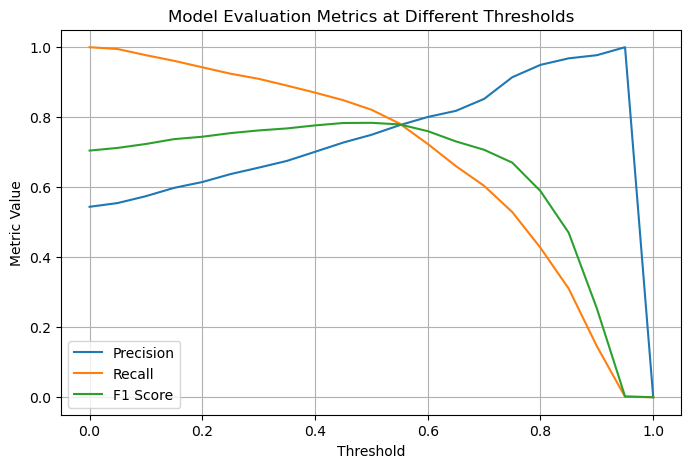

In [14]:
precision = np.array(metrics_history['precision'])
recall = np.array(metrics_history['recall'])
f1 = np.array(metrics_history['f1'])

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Model Evaluation Metrics at Different Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### KFold Cross-Validation

In [15]:
X_train_full = df_train_full[features]
y_train_full = df_train_full['satisfaction']

metrics_history = {
    'roc_auc': [], 
    'precision': [], 
    'recall': [], 
    'f1': []
}

C_values = [0.001, 0.01, 0.1, 1, 10]

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
for C in C_values:
    aucs = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
        
    for train_index, val_index in kf.split(X_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
            
        model = LogisticRegression(C=C, solver='liblinear', random_state=RANDOM_STATE)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
            
        metrics = evaluate(y_val, y_pred_proba)
            
        aucs.append(metrics['roc_auc'])
        precisions.append(metrics['precision'])
        recalls.append(metrics['recall'])
        f1s.append(metrics['f1'])
        
    print(f'C={C}, auc = {np.mean(aucs):.3f} ± {np.std(aucs):.3f}')
    print(f'C={C}, precision = {np.mean(precisions):.3f} ± {np.std(precisions):.3f}')
    print(f'C={C}, recall = {np.mean(recalls):.3f} ± {np.std(recalls):.3f}')
    print(f'C={C}, f1 = {np.mean(f1s):.3f} ± {np.std(f1s):.3f}')
    print('---------------')

C=0.001, auc = 0.735 ± 0.001
C=0.001, precision = 0.734 ± 0.003
C=0.001, recall = 0.833 ± 0.002
C=0.001, f1 = 0.781 ± 0.000
---------------
C=0.01, auc = 0.750 ± 0.003
C=0.01, precision = 0.754 ± 0.003
C=0.01, recall = 0.826 ± 0.002
C=0.01, f1 = 0.788 ± 0.002
---------------
C=0.1, auc = 0.751 ± 0.003
C=0.1, precision = 0.755 ± 0.003
C=0.1, recall = 0.822 ± 0.002
C=0.1, f1 = 0.787 ± 0.002
---------------
C=1, auc = 0.751 ± 0.003
C=1, precision = 0.756 ± 0.003
C=1, recall = 0.820 ± 0.002
C=1, f1 = 0.787 ± 0.002
---------------
C=10, auc = 0.751 ± 0.003
C=10, precision = 0.756 ± 0.003
C=10, recall = 0.821 ± 0.002
C=10, f1 = 0.787 ± 0.002
---------------


### Logistic Regression Summary and Conclusions

After hyperparameter tuning and cross-validation, the Logistic Regression model demonstrates strong performance on the validation set. The key metrics are as follows:

- **AUC**: 0.751 ± 0.003
- **Precision**: 0.756 ± 0.003
- **Recall**: 0.820 ± 0.002
- **F1 Score**: 0.787 ± 0.002

#### Key Takeaways:

1. **Moderate AUC**: The AUC of 0.751 indicates that the model has a reasonable measure of separability, although there is room for improvement in distinguishing between the positive and negative classes.

2. **Balanced Precision and Recall**: The model has a precision of 0.756 and a recall of 0.820, suggesting that it is fairly precise and sensitive to the positive class.

3. **Good F1 Score**: An F1 score of 0.787 is indicative of a balanced model, which is a harmonic mean of precision and recall.

4. **Consistency**: The low standard deviation in the metrics suggests that the model is robust and not overfitting.

## Random Forest

In [16]:
df_train, df_val, df_test, df_train_full = split_data(df, features)
X_train, y_train = split_x_y(df_train)
X_val, y_val = split_x_y(df_val)

### Hyperparameter Tuning: Max Depth

We will start by tuning the `max_depth` parameter and observe its impact on various metrics.

In [17]:
n_estimators_values = range(10, 201, 10)
depth_values = [5, 10, 20]
metrics_history_depth = evaluate_param(
    'max_depth', depth_values, n_estimators_values, X_train, y_train, X_val, y_val)

max_depth: 5
max_depth: 10
max_depth: 20


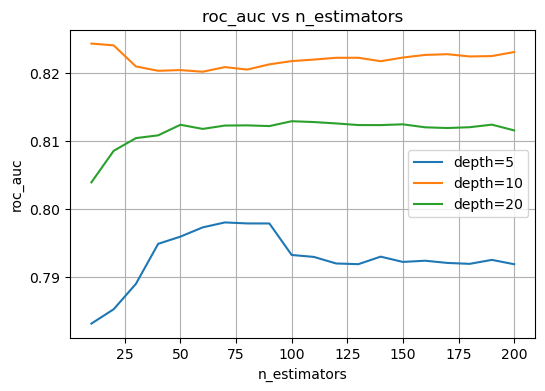

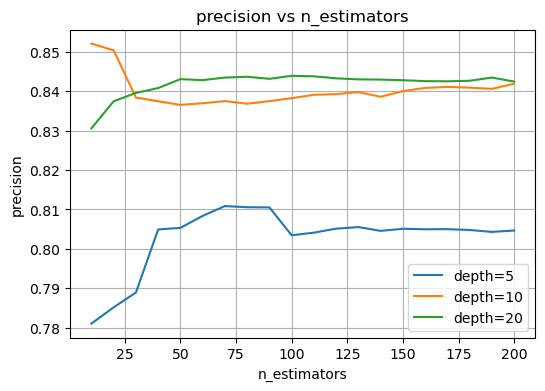

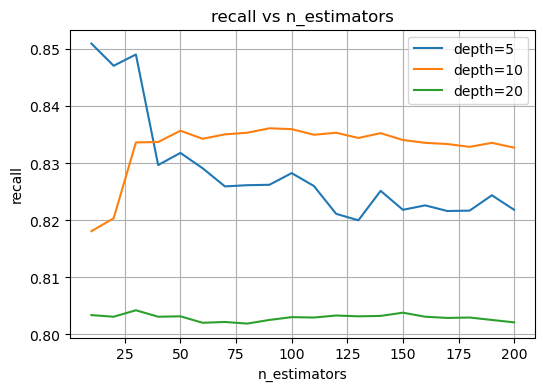

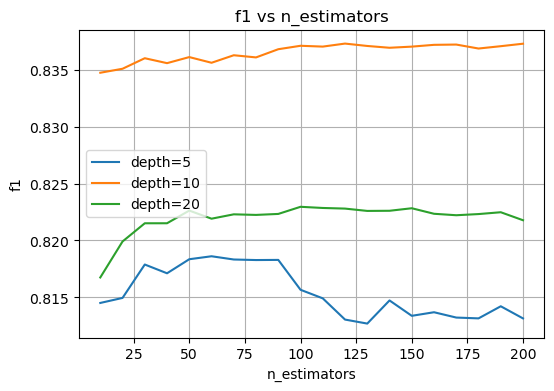

In [18]:
plot_evaluation(metrics_history_depth, n_estimators_values, 'depth', 'n_estimators')

### Hyperparameter Tuning: Min Samples Leaf

Next, we will tune the `min_samples_leaf` parameter while keeping `max_depth` fixed at 10.

In [19]:
min_samples_leaf_values = [3, 5, 10]
metrics_history_min_samples = evaluate_param('min_samples_leaf', 
                                             min_samples_leaf_values, 
                                             n_estimators_values, 
                                             X_train, y_train, X_val, y_val, 
                                             fixed_params={'max_depth': 10})

min_samples_leaf: 3
min_samples_leaf: 5
min_samples_leaf: 10


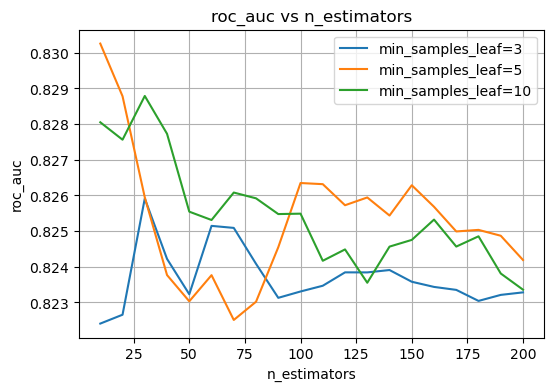

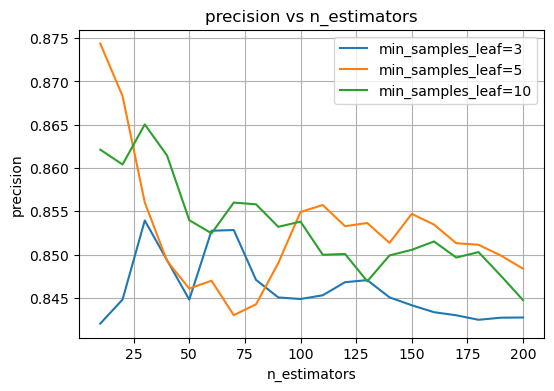

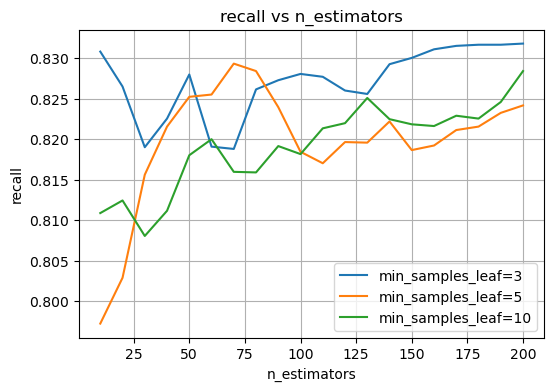

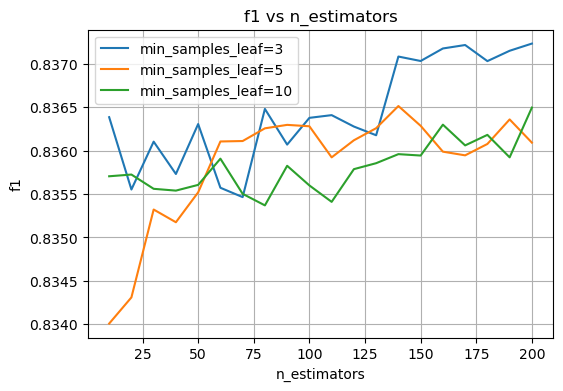

In [20]:
plot_evaluation(metrics_history_min_samples, n_estimators_values, 'min_samples_leaf', 'n_estimators')

### Cross-Validation

Finally, we will perform 5-fold cross-validation to assess the model's performance.

In [21]:
X_train_full = df_train_full[features]
y_train_full = df_train_full['satisfaction']

rf_model = RandomForestClassifier(n_estimators=25, 
                               max_depth=10, 
                               min_samples_leaf=10,
                               random_state=RANDOM_STATE)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
aucs = []
accuracies = []
precisions = []
recalls = []
f1s = []
    
for train_index, val_index in kf.split(X_train_full):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        
    rf_model.fit(X_train, y_train)
    y_pred_proba = rf_model.predict_proba(X_val)[:, 1]
        
    metrics = evaluate(y_val, y_pred_proba)
        
    aucs.append(metrics['roc_auc'])
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1s.append(metrics['f1'])
    
print(f'auc = {np.mean(aucs):.3f} ± {np.std(aucs):.3f}')
print(f'precision = {np.mean(precisions):.3f} ± {np.std(precisions):.3f}')
print(f'recall = {np.mean(recalls):.3f} ± {np.std(recalls):.3f}')
print(f'f1 = {np.mean(f1s):.3f} ± {np.std(f1s):.3f}')

auc = 0.825 ± 0.002
precision = 0.856 ± 0.007
recall = 0.816 ± 0.010
f1 = 0.835 ± 0.002


### Random Forest Summary and Conclusions

After hyperparameter tuning and cross-validation, the Random Forest model demonstrates strong performance on the validation set. The key metrics are as follows:

- **AUC**: 0.825 ± 0.002
- **Precision**: 0.856 ± 0.007
- **Recall**: 0.816 ± 0.010
- **F1 Score**: 0.835 ± 0.002

#### Key Takeaways:

1. **High AUC**: The AUC of 0.825 indicates that the model has a good measure of separability and is capable of distinguishing between the positive and negative classes effectively.

2. **Balanced Precision and Recall**: The model has a high precision of 0.856 and a good recall of 0.816, suggesting that it is both precise and sensitive.

3. **Strong F1 Score**: An F1 score of 0.835 is indicative of a well-balanced model, which is a harmonic mean of precision and recall.

4. **Consistency**: The low standard deviation in the metrics suggests that the model is robust and not overfitting.


## XGBoost

In [22]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

### Tuning the Learning Rate (`eta`)

Training model with eta = 0.1
[0]	train-auc:0.89048	val-auc:0.88995
[10]	train-auc:0.89662	val-auc:0.89617
[20]	train-auc:0.89966	val-auc:0.89892
[30]	train-auc:0.90168	val-auc:0.90025
[40]	train-auc:0.90634	val-auc:0.90426
[50]	train-auc:0.90836	val-auc:0.90533
[60]	train-auc:0.90952	val-auc:0.90558
[70]	train-auc:0.91052	val-auc:0.90585
[80]	train-auc:0.91112	val-auc:0.90592
[90]	train-auc:0.91205	val-auc:0.90600
[99]	train-auc:0.91252	val-auc:0.90599
Training model with eta = 0.3
[0]	train-auc:0.89048	val-auc:0.88995
[10]	train-auc:0.90491	val-auc:0.90312
[20]	train-auc:0.91009	val-auc:0.90594
[30]	train-auc:0.91218	val-auc:0.90577
[40]	train-auc:0.91397	val-auc:0.90585
[50]	train-auc:0.91642	val-auc:0.90597
[60]	train-auc:0.91832	val-auc:0.90553
[70]	train-auc:0.91992	val-auc:0.90533
[80]	train-auc:0.92163	val-auc:0.90495
[90]	train-auc:0.92309	val-auc:0.90486
[99]	train-auc:0.92380	val-auc:0.90472
Training model with eta = 0.5
[0]	train-auc:0.89048	val-auc:0.88995
[10]	train-auc:0

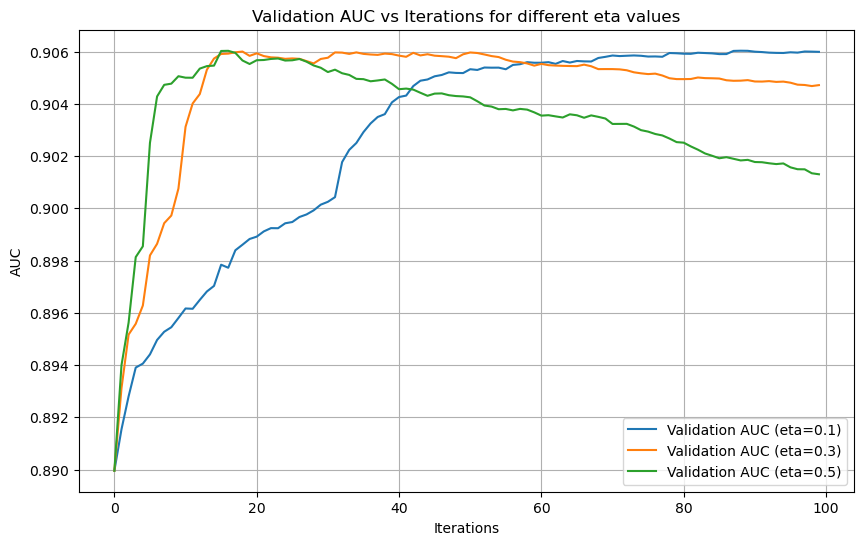

In [23]:
plot_xgb_metrics([0.1, 0.3, 0.5], 'eta', dtrain, dval)

### Tuning the Maximum Depth (`max_depth`)

Training model with max_depth = 3
[0]	train-auc:0.84436	val-auc:0.84553
[10]	train-auc:0.88557	val-auc:0.88522
[20]	train-auc:0.89400	val-auc:0.89359
[30]	train-auc:0.89664	val-auc:0.89638
[40]	train-auc:0.89854	val-auc:0.89800
[50]	train-auc:0.89985	val-auc:0.89920
[60]	train-auc:0.90059	val-auc:0.89950
[70]	train-auc:0.90112	val-auc:0.89991
[80]	train-auc:0.90186	val-auc:0.90049
[90]	train-auc:0.90250	val-auc:0.90089
[99]	train-auc:0.90309	val-auc:0.90103
Training model with max_depth = 6
[0]	train-auc:0.89048	val-auc:0.88995
[10]	train-auc:0.90491	val-auc:0.90312
[20]	train-auc:0.91009	val-auc:0.90594
[30]	train-auc:0.91218	val-auc:0.90577
[40]	train-auc:0.91397	val-auc:0.90585
[50]	train-auc:0.91642	val-auc:0.90597
[60]	train-auc:0.91832	val-auc:0.90553
[70]	train-auc:0.91992	val-auc:0.90533
[80]	train-auc:0.92163	val-auc:0.90495
[90]	train-auc:0.92309	val-auc:0.90486
[99]	train-auc:0.92380	val-auc:0.90472
Training model with max_depth = 10
[0]	train-auc:0.90752	val-auc:0.90047
[10

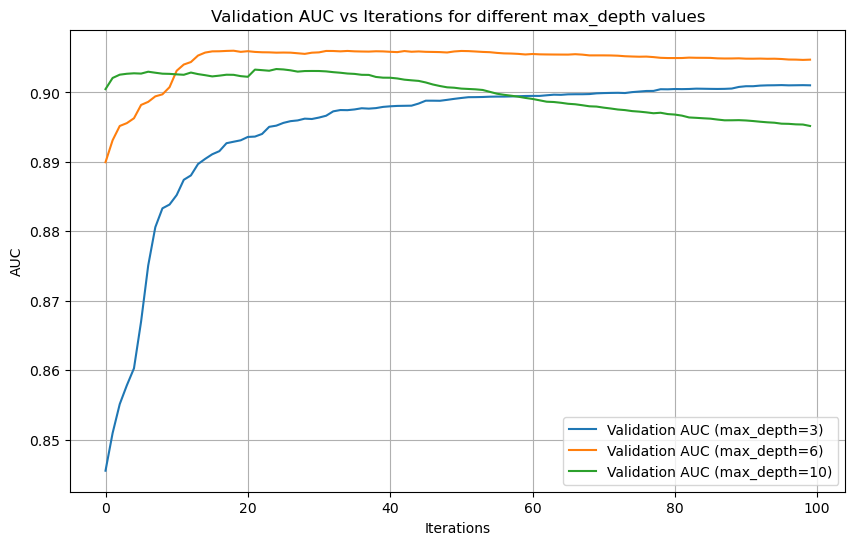

In [24]:
plot_xgb_metrics([3, 6, 10], 'max_depth', dtrain, dval, eta=0.3)

### Tuning the Minimum Child Weight (`min_child_weight`)


Training model with min_child_weight = 1
[0]	train-auc:0.89048	val-auc:0.88995
[10]	train-auc:0.90491	val-auc:0.90312
[20]	train-auc:0.91009	val-auc:0.90594
[30]	train-auc:0.91218	val-auc:0.90577
[40]	train-auc:0.91397	val-auc:0.90585
[50]	train-auc:0.91642	val-auc:0.90597
[60]	train-auc:0.91832	val-auc:0.90553
[70]	train-auc:0.91992	val-auc:0.90533
[80]	train-auc:0.92163	val-auc:0.90495
[90]	train-auc:0.92309	val-auc:0.90486
[99]	train-auc:0.92380	val-auc:0.90472
Training model with min_child_weight = 5
[0]	train-auc:0.89044	val-auc:0.89000
[10]	train-auc:0.90446	val-auc:0.90288
[20]	train-auc:0.90937	val-auc:0.90594
[30]	train-auc:0.91181	val-auc:0.90636
[40]	train-auc:0.91392	val-auc:0.90655
[50]	train-auc:0.91539	val-auc:0.90618
[60]	train-auc:0.91657	val-auc:0.90606
[70]	train-auc:0.91810	val-auc:0.90558
[80]	train-auc:0.91912	val-auc:0.90546
[90]	train-auc:0.92004	val-auc:0.90540
[99]	train-auc:0.92108	val-auc:0.90517
Training model with min_child_weight = 10
[0]	train-auc:0.8903

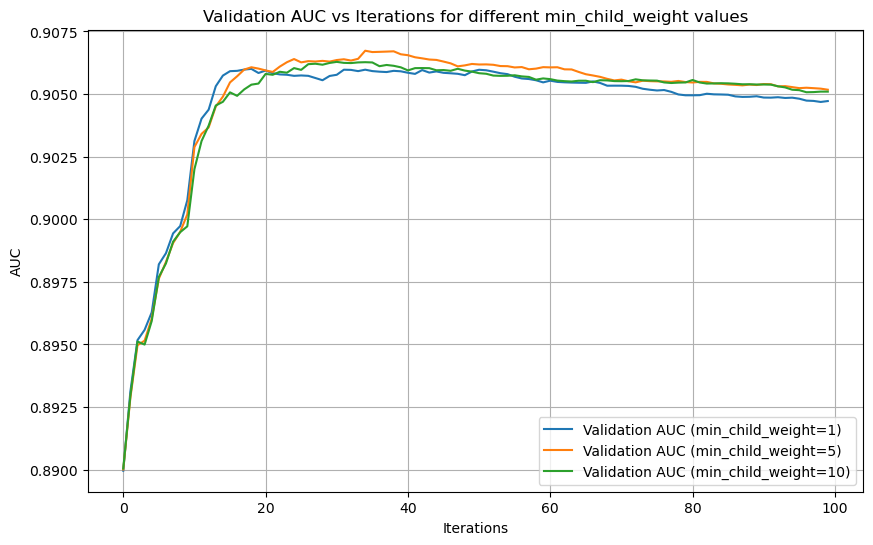

In [25]:
plot_xgb_metrics([1, 5, 10], 'min_child_weight', dtrain, dval, eta=0.3, max_depth=6)

### Cross-Validation

In [26]:
xgb_params = get_xgb_params(min_child_weight=10)
dtrain = xgb.DMatrix(X_train_full, label=y_train_full)

metrics_storage = {
        'auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
for train_index, val_index in kf.split(dtrain.get_label()):
    dtrain_fold = dtrain.slice(train_index)
    dval_fold = dtrain.slice(val_index)
        
    xgb_model = xgb.train(xgb_params, dtrain_fold, num_boost_round=25)
    y_pred_proba = xgb_model.predict(dval_fold)
    y_true = dtrain.get_label()[val_index]
        
    metrics_storage['auc'].append(roc_auc_score(y_true, y_pred_proba))
    y_pred = (y_pred_proba > 0.5).astype(int)
    metrics_storage['precision'].append(precision_score(y_true, y_pred))
    metrics_storage['recall'].append(recall_score(y_true, y_pred))
    metrics_storage['f1'].append(f1_score(y_true, y_pred))
        
for metric, values in metrics_storage.items():
    mean_value = np.mean(values)
    std_value = np.std(values)
    print(f"{metric} = {mean_value:.3f} ± {std_value:.3f}")

auc = 0.905 ± 0.001
precision = 0.870 ± 0.009
recall = 0.801 ± 0.009
f1 = 0.834 ± 0.001


### XGBoost Summary and Conclusions

After hyperparameter tuning and cross-validation, the XGBoost model demonstrates excellent performance on the validation set. The key metrics are as follows:

- **AUC**: 0.905 ± 0.001
- **Precision**: 0.870 ± 0.009
- **Recall**: 0.801 ± 0.009
- **F1 Score**: 0.834 ± 0.001

#### Key Takeaways:

1. **Exceptional AUC**: The AUC of 0.905 indicates that the model has an excellent measure of separability and is highly capable of distinguishing between the positive and negative classes.

2. **High Precision**: A precision of 0.870 suggests that the model is very accurate in predicting the positive class.

3. **Good Recall**: A recall of 0.801 means the model is sensitive enough to detect the majority of the positive cases.

4. **Strong F1 Score**: An F1 score of 0.834 is indicative of a well-balanced model, which is a harmonic mean of precision and recall.

5. **Consistency**: The low standard deviation in the metrics suggests that the model is robust and not overfitting.


## Overall Summary and Conclusions

After hyperparameter tuning and cross-validation, we have evaluated the performance of three different models: Logistic Regression, Random Forest, and XGBoost. Below are the key metrics for each model:

### Model Performance Summary:

| Model               | AUC       | Precision | Recall  | F1 Score |
|---------------------|-----------|-----------|---------|----------|
| Logistic Regression | 0.751 ± 0.003 | 0.756 ± 0.003 | 0.820 ± 0.002 | 0.787 ± 0.002 |
| Random Forest       | 0.825 ± 0.002 | 0.856 ± 0.007 | 0.816 ± 0.010 | 0.835 ± 0.002 |
| XGBoost             | 0.905 ± 0.001 | 0.870 ± 0.009 | 0.801 ± 0.009 | 0.834 ± 0.001 |

#### Key Takeaways:

1. **Best AUC**: XGBoost has the highest AUC, making it the best model in terms of distinguishing between the positiveand negative classes.

2. **Precision and Recall**: Random Forest and XGBoost both offer a good balance between precision and recall, making them suitable for applications where both false positives and false negatives have significant costs.

3. **F1 Score**: All three models have strong F1 scores, indicating well-balanced models. However, Random Forest and XGBoost slightly outperform Logistic Regression.

4. **Consistency**: All models show low standard deviations in their metrics, indicating that they are robust and not overfitting.

### Final Conclusions:

- **XGBoost** appears to be the most promising model for this classification problem, offering the highest AUC and strong performance across all metrics.
  
- **Random Forest** also performs well and could be considered as an alternative, especially if interpretability is a concern.

- **Logistic Regression**, while simpler and easier to interpret, lags slightly in performance but could still be useful depending on the specific business needs and constraints.

